In [3]:
using Revise
using RCall

using HypergraphNB
using Arpack
using MultivariateStats

In [107]:
N = [50, 50, 100, 50]
C = [NaN, 10, 10, 10]
P = [NaN, .9, .2, .8]

H = plantedPartitionHypergraph(N, C, P);

z = vcat([repeat([z], N[z]) for z ∈ 1:length(N)]...);

# Visualization of the eigenspace

In [108]:
ẑ = z;
B = reducedBPJacobian(H, ẑ);

In [109]:
n_ev = 20
E = Arpack.eigs(B; nev = n_ev, ritzvec = true)            
V = hcat([HypergraphNB.transform_eigenvector(real.(E[2][:,i]), H) for i ∈ 1:n_ev]...);

In [110]:
V_ = 1.0*(V .> 0)
M = fit(PCA, V_; maxoutdim=10)

PCA(indim = 250, outdim = 10, principalratio = 0.8892288435471122)

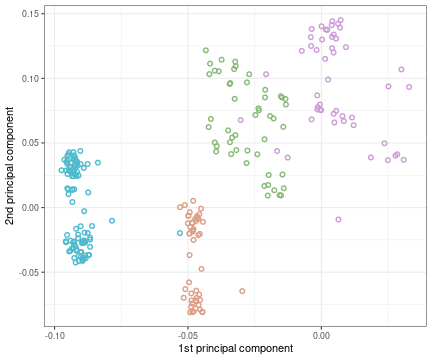

RObject{VecSxp}


In [111]:
R"""
library(tidyverse)
library(colorspace)

df <- tibble(z = $z, m1 = $(M.proj[:,1]), m2 = $(M.proj[:,2]))

p <- df %>% 
    ggplot() + 
    aes(x = m1, y = m2, color = factor(z)) + 
    geom_point(pch = 21, stroke = 1) + 
    theme_bw() +
    xlab("1st principal component") + 
    ylab("2nd principal component") + 
    guides(color = F) + 
    scale_color_discrete_qualitative(palette = "dynamic")

"""

Groups 1, 2, and 3 are the classes 2BIO1, 2BIO2, 2BIO3, which might be imagined to be similar. 

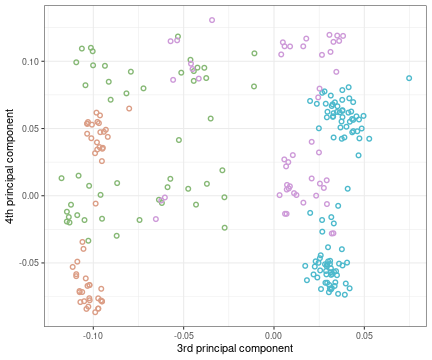

RObject{VecSxp}


In [114]:
R"""

df <- tibble(z = $z, m1 = $(M.proj[:,3]), m2 = $(M.proj[:,4]))

q <- df %>% 
    ggplot() + 
    aes(x = m1, y = m2, color = factor(z)) + 
    geom_point(pch = 21, stroke = 1) + 
    theme_bw() +
    xlab("3rd principal component") + 
    ylab("4th principal component") + 
    guides(color = F) + 
    scale_color_discrete_qualitative(palette = "dynamic")

"""

In [115]:
R"""
library(patchwork)

p / q

ggsave("fig/PCA-synthetic.png", width = 4, height = 6, dpi = 300)
"""


RObject{NilSxp}
NULL


# Comparison against projections

┌ Warning: RCall.jl: Parsed with column specification:
│ cols(
│   ngroups = col_double(),
│   nev = col_double(),
│   tot_SS = col_double(),
│   cost_SS = col_double(),
│   ari = col_double(),
│   round = col_double(),
│   data = col_character()
│ )
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160
┌ Warning: RCall.jl: Parsed with column specification:
│ cols(
│   ngroups = col_double(),
│   nev = col_double(),
│   tot_SS = col_double(),
│   cost_SS = col_double(),
│   ari = col_double(),
│   round = col_double(),
│   data = col_character()
│ )
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


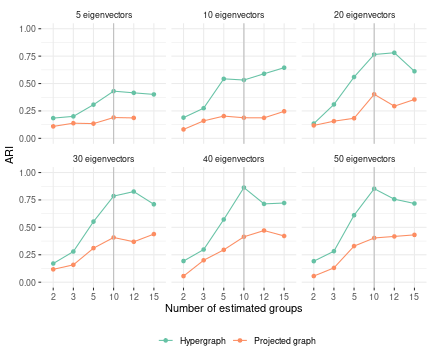

RObject{VecSxp}


In [257]:
R"""
df <- read_csv("throughput/data-throughput/contact-high-school-classes.csv") %>% 
    mutate(projected = "Hypergraph")
df_proj <- read_csv("throughput/data-throughput/contact-high-school-classes-projected.csv") %>% 
    mutate(projected = "Projected graph")

df <- df %>% 
    rbind(df_proj)

to_eig <- 

df %>% 
    mutate(obj = cost_SS / tot_SS) %>% 
    filter(obj > 0) %>% 
    filter(nev > 2) %>% 
    filter(round > 3) %>% 
    group_by(ngroups, nev, projected) %>% 
    filter(obj == min(obj)) %>% 
    filter(row_number() == 1) %>% 
    ggplot() + 
    aes(x = factor(ngroups), y = ari, color = projected, group = projected) +
    geom_line() +     
    geom_point() + 
    geom_vline(aes(xintercept = "10"), color = "grey") + 
    facet_wrap(~nev, labeller = labeller(nev = function(x) {paste(x, "eigenvectors")})) + 
    theme_bw() + 
    theme(strip.background = element_blank(),
          legend.position = "bottom",
          panel.border = element_rect(color = NA)) + 
    scale_color_brewer(palette = "Set2") +
    guides(color = guide_legend(title = element_blank())) + 
    xlab("Number of estimated groups") + 
    ylab("ARI") +
    scale_y_continuous(limits = c(0, 1))
    
"""

In [216]:
using StatsBase
using HypergraphNB
using Arpack
using MultivariateStats
using DataFrames

data_name = "contact-primary-school-classes"
H, z = HypergraphNB.read_hypergraph_data(data_name);
K_ = sort(collect(keys(H.E)))

ẑ = z

n = length(H.N)

c, G = degreeTensor(H, ẑ);
q = 1/n * StatsBase.counts(ẑ)
G_ = zero(G)
for i ∈ 1:length(K_)
    G_[i,:,:] = (G[i,:,:] / ((K_[i] - 1) * c[i]) .- 1) .* q
end

In [217]:
length(unique(z))

11

In [218]:
DF = DataFrame()

for i ∈ 1:length(unique(z))
    name = zeros(0)
    K = zeros(0)
    value = zeros(0)
    for k ∈ 1:size(G_, 1)
        push!(name, i)
        push!(value, G_[k,i,i])
        push!(K, K_[k])
    end
    df = DataFrame(name = name, value = value, K = K)
    DF = vcat(DF, df)
end

In [221]:
DF;

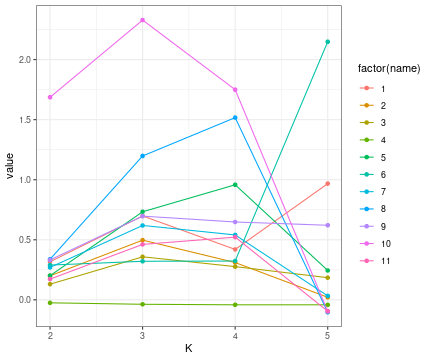

RObject{VecSxp}


In [220]:
R"""


df <- $DF

df %>% 
    ggplot() + 
    aes(x = K, y = value, color = factor(name), group = factor(name)) + 
    geom_line() + 
    geom_point() + 
    theme_bw()

"""